In [1]:
# !conda install pytorch torchvision cuda90 -c pytorch -y
# ! pip install qn

In [2]:

%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
import torch
from torch.autograd import Variable,grad
from torch import nn, optim
import torch.nn.functional as F
import qn
import numpy as np

import plot
from model import DisNet, GenNet
import sampler
from progress import Progress

def cuda(tensor):
    return tensor.cuda() if torch.cuda.is_available() else tensor

def cpu(tensor):
    return tensor.cpu() if torch.cuda.is_available() else tensor


prog = Progress()
config = qn.load('hyperparams.yml')
batchsize = config['batchsize']
dis_net = cuda(DisNet(config['dim_x']))
gen_net = cuda(GenNet(config['dim_z'],config['dim_x']))

dis_optim = optim.Adam(dis_net.parameters(), lr=config['dis_lr'],
    betas=(config['dis_beta1'],config['dis_beta2']))
gen_optim = optim.Adam(gen_net.parameters(), lr=config['gen_lr'],
    betas=(config['gen_beta1'],config['gen_beta2']))


500 82.83826851844788


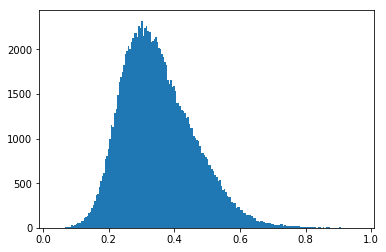

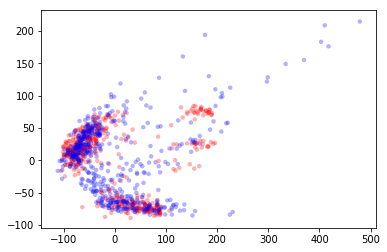

KeyboardInterrupt: 

In [6]:
prog.start()
for i in range(config['num_updates']):
    for _ in range(config['num_critic']):
        samples_true_numpy = sampler.sample_x(batchsize)
        samples_true = Variable(cuda(torch.from_numpy(samples_true_numpy)))
        z = sampler.sample_z(batchsize,config['dim_z'])
        z = Variable(cuda(torch.from_numpy(z)))
        samples_fake = gen_net(z).detach()
        samples_fake_numpy = cpu(samples_fake.data).numpy()      

        eps = np.random.uniform(size=batchsize).astype('float32')
        eps2 = 1 - eps
        # use transpose to broadcast
        samples_mid_numpy = (samples_true_numpy.T*eps).T + \
            (samples_fake_numpy.T*eps2).T
        samples_mid = Variable(cuda(torch.from_numpy(
            samples_mid_numpy)),requires_grad=True)
        f_mid = dis_net(samples_mid)
        # [0]:outputs tuple
        # torch.ones(): grad can be implicitly created only for scalar outputs
        grad_mid = grad(f_mid,samples_mid,cuda(torch.ones(f_mid.size())),
            create_graph=True)[0]
        grad_mid_norm = grad_mid.norm(dim=1)
        diff = (grad_mid_norm - 1).pow(2)

        f_true = dis_net(samples_true)
        f_fake = dis_net(samples_fake)
        loss_critic = f_fake.mean() - f_true.mean() + \
            (config['lda']*diff).mean()
        prog.add_loss_critic(cpu(loss_critic.data).numpy()[0])

        dis_optim.zero_grad()
        loss_critic.backward()
        dis_optim.step()

    prog.add_loss_dis()
    z = sampler.sample_z(batchsize,config['dim_z'])
    z = Variable(cuda(torch.from_numpy(z)))
    samples_fake = gen_net(z)
    f_fake = dis_net(samples_fake)
    loss_gen = -f_fake.mean()
    prog.add_loss_gen(cpu(loss_gen.data).numpy()[0])

    gen_optim.zero_grad()
    loss_gen.backward()
    gen_optim.step()

    if (i+1)%config['num_plot'] == 0:
        print(i+1,prog.duration())
        z = sampler.sample_z(500,config['dim_z'])
        z = Variable(cuda(torch.from_numpy(z)))
        samples_fake = cpu(gen_net(z).data).numpy()
        plot.plot_corr(samples_fake, filename='{}_corr'.format(i+1),show=True)
        plot.plot_scatter(sampler.mat[:,:500].T,samples_fake[:500,:],
            filename='{}_scatter'.format(i+1),show=True)
        prog.start()
prog.plot()


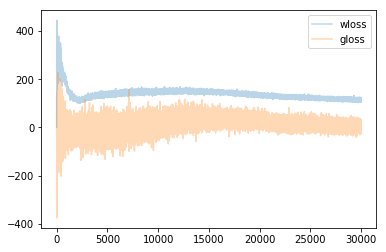

DisNet(
  (fc1): Linear(in_features=6605, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=600, bias=True)
  (fc3): Linear(in_features=600, out_features=1, bias=True)
)

In [5]:
prog.plot()
dis_net

In [ ]:
torch.save(dis_net.state_dict(),'models/model_1/dis_net.pt')
torch.save(gen_net.state_dict(),'models/model_1/gen_net.pt')
!cp model.py models/model_1/